In [1]:
import tensorflow as tf
import tensorflow_docs as tfdocs
import tensorflow_docs.modeling
import tensorflow_docs.plots
import numpy as np
import matplotlib.pyplot as plt
from tensorflow import keras
from keras_preprocessing import image
from keras_preprocessing.image import ImageDataGenerator

class_names = ['0', '1', '2', '3', 
               '4', '5', '6', '7', 
               '8', '9']
number_of_classes = 10

Found 87629 images belonging to 10 classes.
Found 21901 images belonging to 10 classes.


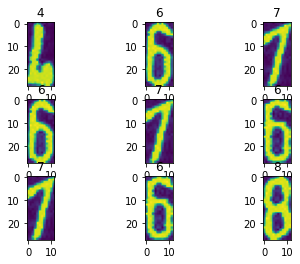

In [2]:
ds = ImageDataGenerator(
    rescale=1.0/255, 
    validation_split=0.2,
    fill_mode='constant',
    cval=0
)

train_ds = ds.flow_from_directory(
    "../numberLabel", 
    target_size=(28,12), 
    batch_size=256,
    subset='training',
    color_mode='grayscale',
    class_mode='sparse'
)

validation_ds = ds.flow_from_directory(
    "../numberLabel", 
    target_size=(28,12), 
    batch_size=256,
    subset='validation',
    color_mode='grayscale',
    class_mode='sparse'
)

input_shape = train_ds[0][0][0].shape

fig, axs = plt.subplots(3,3)
plt.rcParams["figure.figsize"] = (14,14)

for i in range(3):
    for j in range(3):
        axs[i, j].imshow(validation_ds[0][0][i + j])
        axs[i, j].set_title(class_names[int(validation_ds[0][1][i + j])])

In [3]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Input((28,12,1)),
    tf.keras.layers.Conv2D(16, (3,3), activation='elu',
                           kernel_regularizer=tf.keras.regularizers.l2(1e-3), 
                           padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(16, (3,3), activation='elu',
                           kernel_regularizer=tf.keras.regularizers.l2(1e-3), 
                           padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(32, (3,3), activation='elu', 
                           kernel_regularizer=tf.keras.regularizers.l2(1e-3), 
                           padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(32, (3,3), activation='elu',
                           kernel_regularizer=tf.keras.regularizers.l2(1e-3), 
                           padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation='elu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(64, activation='elu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(10, activation='softmax')
])

In [4]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 12, 16)        160       
_________________________________________________________________
batch_normalization (BatchNo (None, 28, 12, 16)        64        
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 12, 16)        2320      
_________________________________________________________________
batch_normalization_1 (Batch (None, 28, 12, 16)        64        
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 6, 16)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 6, 32)         4640      
_________________________________________________________________
batch_normalization_2 (Batch (None, 14, 6, 32)         1

In [5]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss='sparse_categorical_crossentropy',
              metrics=[tf.keras.losses.SparseCategoricalCrossentropy(),
                       'accuracy'])

In [6]:
class stopCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}) :
        if (logs.get('val_accuracy') >= 0.999 and logs.get('accuracy') >= 0.999) :
            print('\nReached 99% accuracy so stopping training')
            self.model.stop_training = True

model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath='D:\\Code\\AI\\Model\\NumberRecognitionModel\\version6.hdf5',
                                                               monitor='val_loss',
                                                               mode='min',
                                                               save_best_only=True)

In [7]:
callback = stopCallback()

history = model.fit(train_ds, 
                    epochs=125, 
                    callbacks=[callback, model_checkpoint_callback], 
                    validation_data=validation_ds)

Epoch 1/125
 32/343 [=>............................] - ETA: 5:16 - loss: 1.9062 - sparse_categorical_crossentropy: 1.8337 - accuracy: 0.3951

KeyboardInterrupt: 

In [ ]:
H = {}
H['number'] = history
plotter = tfdocs.plots.HistoryPlotter(metric='sparse_categorical_crossentropy', smoothing_std=10)
plotter.plot(H)
plt.ylim(0, 3)